In [1]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import pandas as pd
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import learning_curve
from joblib import dump, load

In [2]:
warnings.simplefilter("ignore")

In [3]:
#Mean Euclidean Error Function
def MEE(y_real, y_pred):
    sum_t = 0
    for i in range(len(y_real)):
        sum_t += np.sqrt(np.power((y_real[i][0]-y_pred[i][0]), 2)+np.power((y_real[i][1]-y_pred[i][1]), 2))
    return sum_t / len(y_real)

MEE=make_scorer(MEE, greater_is_better=False)

In [4]:
#Importing the dataset 
X_dev=pd.read_csv("../data/X_dev.csv")
y_dev=pd.read_csv("../data/y_dev.csv")

In [5]:
X_dev=X_dev.to_numpy()
y_dev=y_dev.to_numpy()

In [6]:
kf = KFold(n_splits=5, random_state=None, shuffle=True)

In [7]:
pipe_svr = Pipeline([('reg', MultiOutputRegressor(SVR()))])

grid_param_svr = {
    'reg__estimator__C':[5, 8, 10, 12, 15],
    'reg__estimator__gamma':[0.01, 0.1, 0.5],
    'reg__estimator__epsilon':[0.01, 0.1, 0.2, 0.5, 0.9, 1]
}

gs_svr = (GridSearchCV(estimator=pipe_svr, 
                      param_grid=grid_param_svr, 
                      cv=kf,
                      scoring = MEE,
                      n_jobs = -1))

gs_svr = gs_svr.fit(X_dev,y_dev) 
resultGSCV=pd.DataFrame(gs_svr.cv_results_)
resultGSCV.to_csv(r'SVR_GS_RES.csv')

In [8]:
gs_svr.best_params_

{'reg__estimator__C': 8,
 'reg__estimator__epsilon': 0.2,
 'reg__estimator__gamma': 0.1}

In [9]:
mor=MultiOutputRegressor(SVR(C=gs_svr.best_params_['reg__estimator__C'], gamma=gs_svr.best_params_['reg__estimator__gamma'],
                            epsilon=gs_svr.best_params_['reg__estimator__epsilon']))

train_sizes, train_scores, valid_scores = learning_curve(
    mor, X_dev, y_dev, cv=kf, scoring=MEE)

morB=MultiOutputRegressor(SVR(C=gs_svr.best_params_['reg__estimator__C'], gamma=gs_svr.best_params_['reg__estimator__gamma'],
                            epsilon=gs_svr.best_params_['reg__estimator__epsilon']))
morB.fit(X_dev, y_dev)
dump(morB, 'Models/SVR.joblib')


['Models/SVR.joblib']

In [10]:
train_scores_mean = -train_scores.mean(axis=1)
validation_scores_mean = -valid_scores.mean(axis=1)

train_scores_sd= -train_scores.std(axis=1)
validation_scores_sd = -valid_scores.std(axis=1)

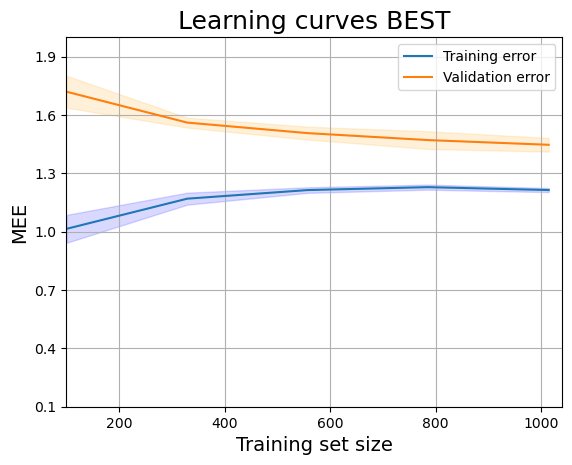

In [27]:
plt.style.use('default')

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.fill_between(train_sizes, train_scores_mean - train_scores_sd, train_scores_mean + train_scores_sd, 
                 color='b', alpha=0.15)

plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_sd, 
                 validation_scores_mean + validation_scores_sd, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves BEST', fontsize = 18)
plt.legend()
plt.ylim(0.1, 2)
plt.xlim(100,1040)
plt.yticks(np.arange(0.1, 2, +0.3))
plt.grid()

In [12]:
print("Best model results:")
print("MEE on the validation",validation_scores_mean[-1],"with standard deviation",validation_scores_sd[-1])
print("MEE on the training",train_scores_mean[-1],"with standard deviation",train_scores_sd[-1])

Best model results:
MEE on the validation 1.4465431275041571 with standard deviation -0.03530947165452205
MEE on the training 1.21383727905854 with standard deviation -0.010626475512304773


In [13]:
mor_HC=MultiOutputRegressor(SVR(C=70, gamma=gs_svr.best_params_['reg__estimator__gamma'],
                            epsilon=gs_svr.best_params_['reg__estimator__epsilon']))

train_sizes_HC, train_scores_HC, valid_scores_HC = learning_curve(
    mor_HC, X_dev, y_dev, cv=kf, scoring=MEE)


In [14]:
train_scores_mean_HC = -train_scores_HC.mean(axis=1)
validation_scores_mean_HC = -valid_scores_HC.mean(axis=1)

train_scores_sd_HC= -train_scores_HC.std(axis=1)
validation_scores_sd_HC = -valid_scores_HC.std(axis=1)

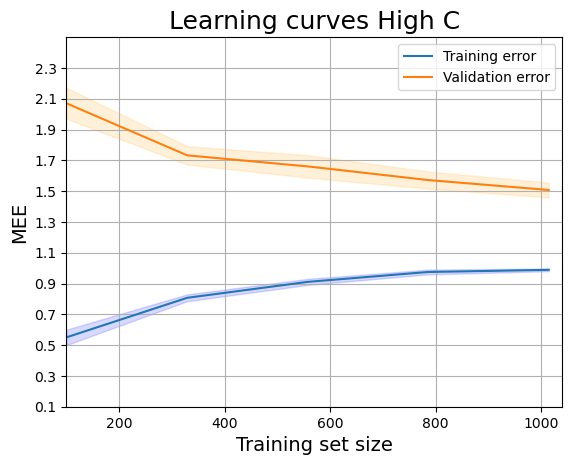

In [29]:
plt.style.use('default')

plt.plot(train_sizes_HC, train_scores_mean_HC, label = 'Training error')
plt.fill_between(train_sizes_HC, train_scores_mean_HC - train_scores_sd_HC, 
                 train_scores_mean_HC + train_scores_sd_HC, 
                 color='b', alpha=0.15)

plt.plot(train_sizes_HC, validation_scores_mean_HC, label = 'Validation error')
plt.fill_between(train_sizes_HC, validation_scores_mean_HC - validation_scores_sd_HC, 
                 validation_scores_mean_HC + validation_scores_sd_HC, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves High C', fontsize = 18)
plt.legend()
plt.xlim(100,1040)
plt.ylim(0.1,2.5)
plt.yticks(np.arange(0.1, 2.5, +0.2))
plt.grid()

In [16]:
print("Very high C results (C=70):")
print("MEE on the validation",validation_scores_mean_HC[-1],"with standard deviation",validation_scores_sd_HC[-1])
print("MEE on the training",train_scores_mean_HC[-1],"with standard deviation",train_scores_sd_HC[-1])

Very high C results (C=70):
MEE on the validation 1.5074167575042436 with standard deviation -0.048192610649576854
MEE on the training 0.9888379408900289 with standard deviation -0.008964262512375335


In [17]:
mor_LC=MultiOutputRegressor(SVR(C=1, gamma=gs_svr.best_params_['reg__estimator__gamma'],
                            epsilon=gs_svr.best_params_['reg__estimator__epsilon']))

train_sizes_LC, train_scores_LC, valid_scores_LC = learning_curve(
    mor_LC, X_dev, y_dev, cv=kf, scoring=MEE)

In [18]:
train_scores_mean_LC = -train_scores_LC.mean(axis=1)
validation_scores_mean_LC = -valid_scores_LC.mean(axis=1)

train_scores_sd_LC= -train_scores_LC.std(axis=1)
validation_scores_sd_LC = -valid_scores_LC.std(axis=1)

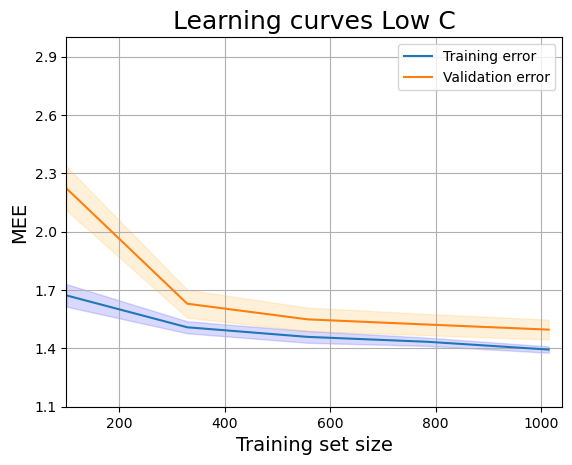

In [31]:
plt.style.use('default')

plt.plot(train_sizes_LC, train_scores_mean_LC, label = 'Training error')
plt.fill_between(train_sizes_LC, train_scores_mean_LC - train_scores_sd_LC, 
                 train_scores_mean_LC + train_scores_sd_LC, 
                 color='b', alpha=0.15)

plt.plot(train_sizes_LC, validation_scores_mean_LC, label = 'Validation error')
plt.fill_between(train_sizes_LC, validation_scores_mean_LC - validation_scores_sd_LC, 
                 validation_scores_mean_LC + validation_scores_sd_LC, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves Low C', fontsize = 18)
plt.legend()
plt.ylim(2,3)
plt.xlim(100,1040)
plt.yticks(np.arange(1.1, 3, +0.3))
plt.grid()

In [20]:
print("Very low C results (C=1):")
print("MEE on the validation",validation_scores_mean_LC[-1],"with standard deviation",validation_scores_sd_LC[-1])
print("MEE on the training",train_scores_mean_LC[-1],"with standard deviation",train_scores_sd_LC[-1])

Very low C results (C=1):
MEE on the validation 1.496362134803779 with standard deviation -0.05102448115438231
MEE on the training 1.3938164661340293 with standard deviation -0.016255303401635217


In [21]:
mor_LE=MultiOutputRegressor(SVR(C=gs_svr.best_params_['reg__estimator__C'], 
                                gamma=gs_svr.best_params_['reg__estimator__gamma'],
                            epsilon=0.001))

train_sizes_LE, train_scores_LE, valid_scores_LE = learning_curve(
    mor_LE, X_dev, y_dev, cv=kf, scoring=MEE)

In [22]:
train_scores_mean_LE = -train_scores_LE.mean(axis=1)
validation_scores_mean_LE = -valid_scores_LE.mean(axis=1)

train_scores_sd_LE= -train_scores_LE.std(axis=1)
validation_scores_sd_LE = -valid_scores_LE.std(axis=1)

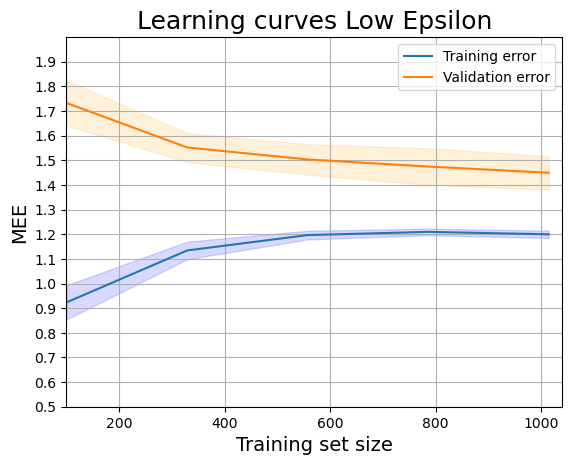

In [32]:
plt.style.use('default')

plt.plot(train_sizes_LE, train_scores_mean_LE, label = 'Training error')
plt.fill_between(train_sizes_LE, train_scores_mean_LE - train_scores_sd_LE, 
                 train_scores_mean_LE + train_scores_sd_LE, 
                 color='b', alpha=0.15)

plt.plot(train_sizes_LE, validation_scores_mean_LE, label = 'Validation error')
plt.fill_between(train_sizes_LE, validation_scores_mean_LE - validation_scores_sd_LE, 
                 validation_scores_mean_LE + validation_scores_sd_LE, 
                 color='orange', alpha=0.15)

plt.ylabel('MEE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves Low Epsilon', fontsize = 18)
plt.legend()
plt.xlim(100,1040)
plt.ylim(0.5, 2)
plt.yticks(np.arange(0.5, 2, +0.1))
plt.grid()

In [24]:
print("Low Epsilon results (epsilon=0.001):")
print("MEE on the validation",validation_scores_mean_LE[-1],"with standard deviation",validation_scores_sd_LE[-1])
print("MEE on the training",train_scores_mean_LE[-1],"with standard deviation",train_scores_sd_LE[-1])

Low Epsilon results (epsilon=0.001):
MEE on the validation 1.4495068665350546 with standard deviation -0.06741715806171765
MEE on the training 1.1997540851297486 with standard deviation -0.01503068987414278
